# Time Series Forecasting of Air Quality Index in Seattle

### John Foster
### Department of Information Technology, Western Governors University
### D214: Data Analytics Graduate Capstone
### Professor Daniel Smith
### July 14, 2023

### A: RESEARCH QUESTION

The research question that I have chosen to explore is as follows: “With what degree of accuracy can a time series model forecast daily AQI values for Seattle, Washington?”

Air Quality Index (AQI), is a metric developed by the US Environmental Protection Agency to warn the American public of dangerous levels of air pollution in a given geographic area (American Lung Association, 2022). Various airborne pollutants contribute to this index, and prolonged outdoor exposure to elevated values are strongly associated with adverse health effects. The construction of a time series model that can accurately forecast these daily values over time for a given region would have multiple practical applications for organizational decision making, including long term planning for regional medical infrastructure development, adjustments to projected taxations on carbon emissions, and even calculations for health insurance premiums.

In order to adequately explore this research question, we have constructed a null hypothesis and an alternative hypothesis that can be objectively tested against the results of our analysis. These hypotheses are as follows:


#### Null Hypothesis 

A time series model cannot be created using the training dataset that generates predictions with a Mean Absolute Percentage Error (MAPE) below 10%.     

                      
#### Alternate Hypothesis

A time series model can be created using the training dataset that generates predictions with a Mean Absolute Percentage Error (MAPE) below 10%.

### B: DATA COLLECTION

The data necessary to perform this analysis will be five years of “daily_aqi_by_cbsa” datasets (2017-2021) acquired from the Environmental Protection Agency’s (EPA) public website (https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI). This year range was selected because 2021 was the most recent year published with complete verified data. This data is collected and maintained by the Environmental Protection Agency and is published for general use on their public-facing website. The datasets contain no sparseness and the total number of observations across every Core Based Statistical Area (CBSA) over our 5 year time period is 856,875. These rows will be filtered based on our target CBSA, with a final observation count of 1,826. The variables contained in this dataset are as follows:

Variable - Data Type

Date - Quantitative
<br>CBSA - Qualitative
<br>CBSA Code - Qualitative
<br>AQI - Quantitative
<br>Category - Qualitative
<br>Defining Parameter - Qualitative
<br>Defining Site - Qualitative
<br>Number of Sites Reporting - Quantitative

By following the included link (https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI), we will click each download link under “Daily AQI by CBSA” for 2017-2021. We can then extract the csv files from their zipped folders and begin interacting with the data via Python.

One advantage of this methodology is the simplicity and ease of the collection process. Because we have elected to use the compiled reports as opposed to complete raw datasets of yearly values, we can very quickly access averaged AQI values across all areporting sites for our intended census area. This ensures a fairly accurate picture of the overall air quality across our census area for each day in the time series.

On the other hand, what we lose by choosing averaged reports over raw data is granularity. The greater King County area is a sprawling metropolitan area situated immediately west of the Cascade mountain range and directly on the coast of the Pacific Ocean. The complex weather patterns that result from this geographic location can create drastically different wind patterns in towns only a few miles apart. Because this analysis is focusing on an index of airborne pollution, the decision to average the values of the entire CBSA almost certainly places a ceiling over the accuracy with which we can confidently forecast an area’s AQI.

We did not encounter any significant challenges in the data collection process itself, as its availability and ease of access effectively made the collection process the simplest phase of our analysis. The EPA website has detailed information regarding various methodologies to access and interact with its data, including a fully functional public API. While that level of control was not necessary for our analysis, it is clear from our experience that the EPA is an organization that places great importance on supplying researchers with as many tools and avenues as is possible to access and analyze its data.


### C: DATA EXTRACTION AND PREPARATION


#### Justification of Tools

Python has been chosen in this analysis due to the author’s familiarity with its conventions as well as its range of available data science libraries. One disadvantage of Python compared to R is that the implementations of the time series models contained in R are often extremely optimized compared to their Python counterparts, leading to much faster computation times, which compound in the context of a grid search. 
The analysis was performed in Jupyter because the notebook format lends itself to the storytelling element necessary for an effective data analysis. One drawback to Jupyter compared to a raw Python script is that it may limit the hardware that could automate this analysis pipeline at scale. VSCode is the author’s IDE of choice and offers many quality-of-life addons that assist in the development of machine learning models, but this improved functionality comes at the cost of higher memory and processor utilization, which would be better allocated to the statistical computations necessary in training a time series model.

Pandas is an industry standard library used predominantly in the generation and manipulation of DataFrame objects, enabling easy interface with the data itself throughout the analysis process. Like VSCode, its wide range of utility unfortunately can also become quite memory intensive when interacting with extremely large datasets. As our own raw dataset in this analysis is over 800,000 observations long, this proved to be a challenging constraint during the early phases of development.

Numpy is a robust toolset of advanced mathematical functions and methods that enable us to perform functions related to exploratory data analysis and interpretations of statistical results. However, the fact that a majority of the underlying code is written in C/C++ and delivered in a Python wrapper necessitates a compiler for those languages to also be present on the machine running the analysis, which eliminates certain scalable microcontroller options in performing similar analyses on a wider range of areas.

Matplotlib includes a wide array of data visualization tools and methods that assist both in the exploration of data and the meaningful presentation of the results of an analysis. Our analysis does not require a large number of advanced visualizations, making this choice of library ideal, but if it did, this function would be better served by utilizing a more extended and robust visualization library built on Matplotlib, such as Seaborn.

Sklearn provides us with the final accuracy metric of our selected model: MAPE. This is a very tidy implementation of this metric, but may be unduly inefficient compared to a manual calculation of MAPE performed via Numpy functions.

Statsmodels gives us access to the classes, functions, and methods necessary to instantiate and compare our time series forecasting models. This library affords us a tremendous amount of granularity and control of our grid search and parameter tuning, which serves our purposes well, but an alternative library such as Prophet also has extensive support for ARIMA/SARIMA modeling with more streamlined optimization algorithms, which would enable us to trade some of our control (and potential accuracy) for ease of development.

For continuity, we will provide a brief description of the data processing steps performed, the advantages/disadvantages of each, and any challenges associated with them alongside their corresponding code snippets below:

First, we will import our necessary libraries.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pickle
import itertools

Next we will use pandas to import our csv files and immediately filter each one down to only include the relevant data using our CBSA code, store them in a dictionary, and concatenate them in a single dataframe that will function as our time series. This is a streamlined and scalable approach to preparing the years of data, but the drawback is that the source csv files must be in the same directory as the notebook file and that they are not renamed in any way.

In [20]:
#Import our time series csvs
cbsa_code = 42660
years = 5
y_start = 2017
dataframes = {}

#Filter the values and store in our dictionary
for i in range(years):
    year = y_start+i
    df = pd.read_csv('daily_aqi_by_cbsa_' + str(year) + '.csv')
    dataframes[year] = df[df['CBSA Code'] == cbsa_code]

#Concatenate the dataframes to our time series
df = pd.concat(dataframes.values())

Now we will change the data type of our Date column to datetime, make it our index, and drop the remaining columns before exporting the prepared dataframe. Exporting the time series before splitting allows flexibility in training and testing size, but increases the number of steps necessary to pre-process the data prior to model fitting.

In [21]:
#Change the data format of the Date column to datetime and make it our index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#Drop the remaining columns
print(df.columns)
for col in df.columns:
    if col not in ['Date', 'AQI']:
        df.drop(columns=col, inplace=True)

#Export our final time series dataframe
df.to_csv('time_series.csv')

Index(['CBSA', 'CBSA Code', 'AQI', 'Category', 'Defining Parameter',
       'Defining Site', 'Number of Sites Reporting'],
      dtype='object')


Next we will split our data into training and testing sets. An 80/20 split was chosen due to the fact that the data encompasses five years, but choosing this division (and this number of training observations) will ultimately make the model take a great deal longer to fit.

In [22]:
#Store our full time series as a variable
time_series = df['AQI']

#Split the series into training and testing sets
train_size = int(0.8 * len(time_series))  # Specify the size of the training set
train_data = time_series[:train_size]
test_data = time_series[train_size:]

This concludes the data extraction and preparation phase

### D: ANALYSIS

Despite the relative simplicity of the final script, this analysis was fraught with obstacles. As we examine the code snippets of each step, we will describe their function in the overall process, as well as advantages and disadvantages of each, any obstacles experienced during their development.

#### Exploratory Data Analysis

Our first step is to evaluate the time series itself. We will begin by plotting the raw series.

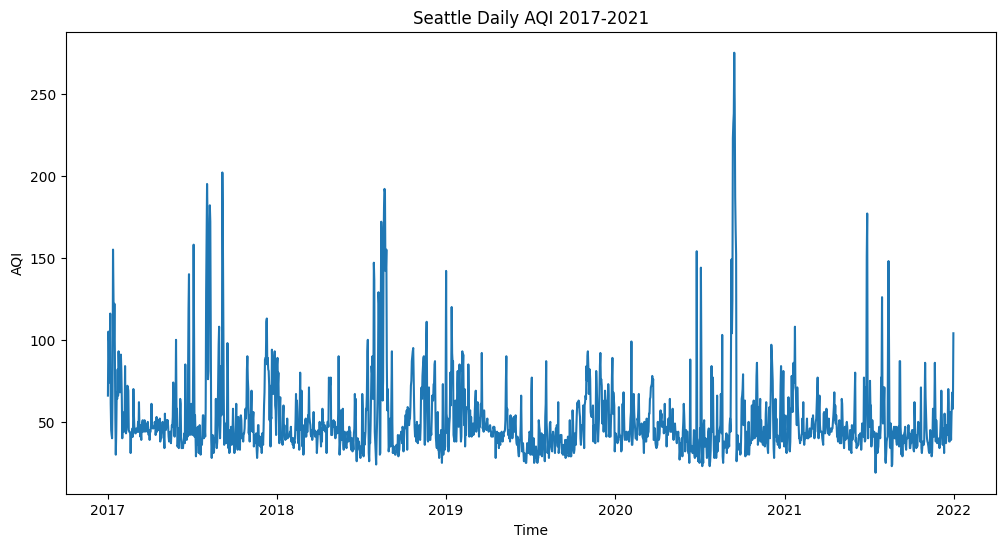

In [23]:
plt.figure(figsize = [12,6])
plt.plot(df['AQI'])
plt.title("Seattle Daily AQI 2017-2021")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.show()

It appears that there is at least some annual seasonality in our data, which is logical considering the annual occurrence of wildfires during the summer months in the Pacific Northwest.

Next, we will perform an augmented Dicky-Fuller (ADF) test to evaluate the time series for stationarity. This is an effective numerical way to evaluate a time series for stationarity, but it is not always an adequate metric to determine that no differencing is necessary, and our grid search will be naive to these results regardless.

In [24]:
ADF = adfuller(time_series)

print('Seasonal ADF statistic: ' + str(ADF[0]))
print('P-value of Seasonal ADF statistic: ' + str(ADF[1]))

Seasonal ADF statistic: -9.191894556571881
P-value of Seasonal ADF statistic: 2.1123543079258765e-15


Based on the P-Value of the ADF test, we can conclude that the data does display stationarity, but we will still include differenced and seasonally differenced models in our grid search in order to find the best-fitting model.

To confirm our suspicions about seasonality, we will perform a seasonal decomposition of the data. In particular, we will evaluate the residuals plot at the bottom. This is an effective way to evaluate for seasonality, but can be limiting in its subjectivity.

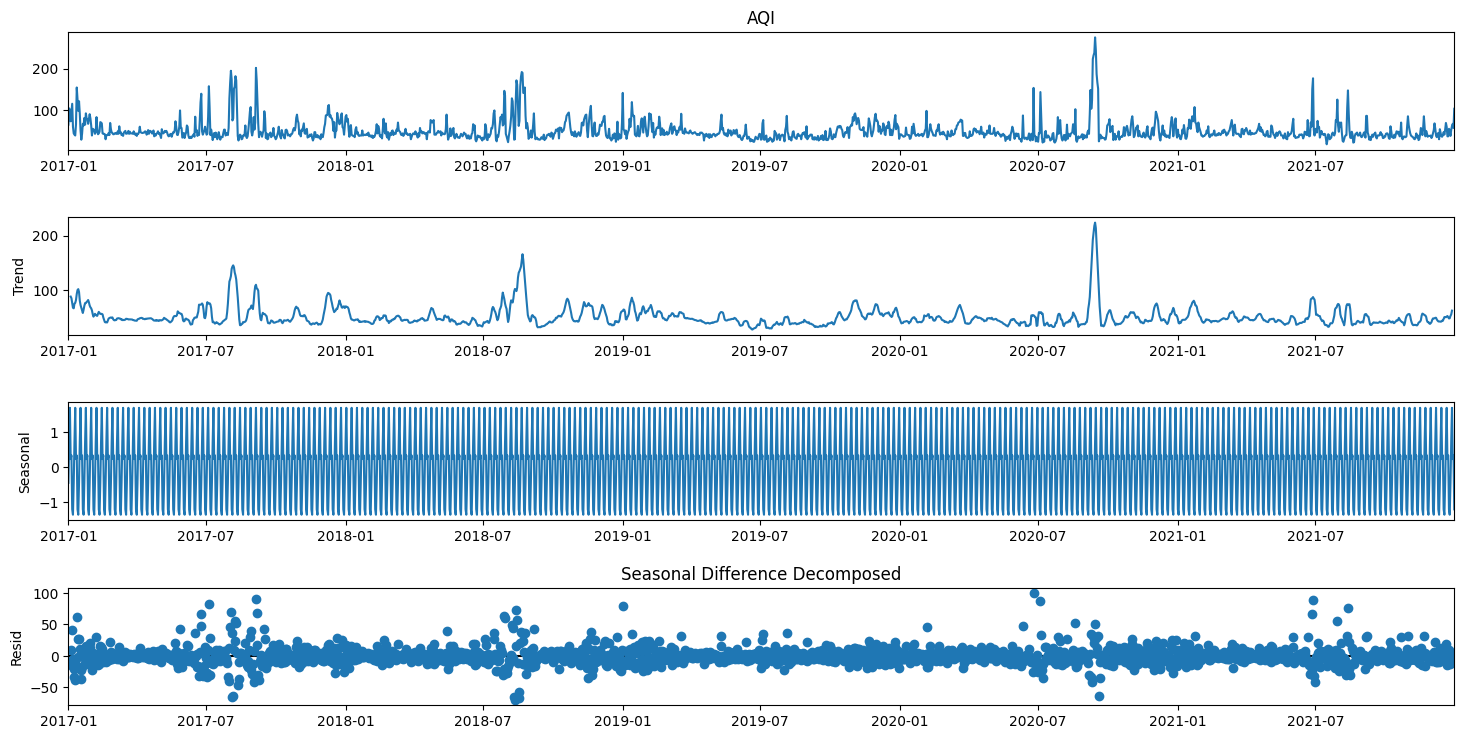

In [25]:
ts_decomp = seasonal_decompose(time_series)
x= ts_decomp.plot()
x.set_size_inches((16, 8))
plt.title('Seasonal Difference Decomposed')
plt.show()

From what we can see in the residuals plot, it appears that there is a significant seasonal pattern around July-August of each year. The raw plot that we created earlier confirms this. We cmight infer that at least a portion of these significant spikes in AQI are the result of annually occurring wildfires in the Pacific Northwest. Regardless, it is clear that seasonal differencing with a periodicity of 365 (to represent one year) should be employed in our chosen model to account for these annual fluctuations. However, this periodicity poses a significant problem in our grid search, as we will describe below.

#### Grid Search

Our choice to implement a custom grid search to identify our optimal model instead of utilizing a library with a prebuilt function (such as ‘pmdarima’) library is due in part to the amount of processing time and resources necessary to execute our grid search. Robust though the auto_arima() method is, on machines with limited computational resources, time series training on a large quantity of observations that incorporates this degree of seasonal differencing will be prohibitively expensive from a computational perspective, and the output of this method regarding estimated time to training completiom leaves something to be desired, assuming the script doesn’t crash in the middle of the search due to excessive memory draw. By manually creating a grid search, we can decide exactly how much feedback we would like to display over the course of the grid search, store a current snapshot of the progress of the search in an external file so that the search can be resumed from any point of interruption, and tailor the methodology of the model selection to minimize memory allocation and prevent crashes. The drawback of this method is, of course, increased complexity in development and the introduction of more potential failure points in our analysis through human error.

Establishing a workable grid search method for our time series model was by far the most challenging piece of this analysis. In our decision to utilize the statsmodels implementation of time series forecasting, we almost certainly made a significant mistake, and in retrospect, this author concludes that the exploration of Meta's Prophet library would be an extremely wise investment of time and effort in the future development of adaptable time series model pipelines. 

The primary issue faced was memory utilization. Using the standard SARIMAX method was impossible and resulted in system crashes, even on a machine with 64GB of RAM clocked at 3600mhz. As a workaround, we had to utilize a method buried in a Github pull request (Fulton, 2019), using a sparsely-documented low-memory alternative implementation of the ARIMA model, allowing us to use our seasonal periodicity of 365 days. As this periodicity seems extremely common in forecasting daily values of data over a variety of subjects, this basic functionality almost certainly belongs in the SARIMAX method, and the lack of visibility for methodologies that are compatible with consumer level hardware is perplexing.

As a final point of note, our seasonal periodicity also prevented us from being able to fit potential models with a seasonal MA value above 1, as the length of our training set ended up being too small for the model to properly train due to the multiplicative interaction between our seasonal periodicity and the order of the model's seasonal moving averaging. This issue could be addressed by simply adding more years with of data to our training set, but this would run afoul of the analysis scope put forth in our project proposal. To comnpensate for this , we added some additional exception handling to our grid search to simply bypass the parameter combinations that fail to fit on the training data.

Itertools enables us to flatten our parameter grid and implement a clean, customizable, and listwise iterative search for optimal model identification purposes. While this implementation is extremely simple and clean to use, it contains unnecessary functionality as well, and a manual implementation of flattening our parameter grid to a list may be more computationally efficient.

The decision to serialize our optimal model using the Pickle library was born completely out of necessity. Our final selected model took nearly 4 hours to fit to our training dataset, and the iterative nature of development made this allocation of time untenable. The advantage of serialization is that the trained model can simply be loaded from a file and interacted with in our script, rather than completely re-fit every time we need to restart the Jupyter kernel, close VSCode, or change code snippets before the grid search and model evaluation process. The drawback of this approach is that the trained model is extremely large-- over 785mb. Even when compressed to a standard zip file, the size of the model exceeds WGU's file submission of 200MB. because of this, we will ultimately opt to compress the entire directory for this analysis, including all scripting, indexing, raw csv, and model files, to a single .7z file, so that the size limitations are not exceeded and all files can be extracted to teh same directory to ensure that the script runs as intended. 

In [26]:
# Define the range of values for each order
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]

# Create a list of all possible combinations of the parameters
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

In [27]:
# If the indexing file exists, read the index of the last completed parameter combination and store the index of the next combination for use in the next model
try:
    with open('index.txt', 'r+') as g:
        try:
            index = eval(g.read()) + 1
        #If the file is blank, store the index as 0.
        except SyntaxError:
            index = 0

#Create and leave the file blank if it doesn't exist, then store the index as 0
except FileNotFoundError:
    with open('index.txt', 'w') as g:
        index = 0

In [28]:
# Define a function to evaluate the SARIMA model with given parameters, 
# with exception handling to move on if the model cannot be fit
def evaluate_sarima(params, y):
    p, d, q, P, D, Q = params
    try:
        model = ARIMA(y, order=(p, d, q), seasonal_order=(P, D, Q, 365), freq='D')
        results = model.fit(method='innovations_mle', low_memory=True)
        return results
    except:
        print('Unable to train model. Passing np.inf')
        return np.inf 
    
#Try to load the best model so far. Load the aic and params if it exists for comparison in the grid search
try:
    with open('arima_model.pickle', 'rb') as f:
        # Load the pickled model
        grid_model_fit = pickle.load(f)
    #Concatenate the order and seasonal order from the fitted model for comparison
    print('Loading previously saved best model')
    best_params = grid_model_fit.specification['order'] + grid_model_fit.specification['seasonal_order'][:-1]
    best_aic = grid_model_fit.aic
#If there is no best model, use these values
except FileNotFoundError:
    print('Best model not found, comparing AIC to np.inf')
    best_aic = np.inf
    best_params = None
# This is the bulk of the grid search itself
try:
    #For every combination of parameters, try to train the model
    for params in param_grid[index:]:
        print(params)
        print('Training model ' + str(param_grid.index(params) + 1) + ' of ' + str(len(param_grid)))
        #Store the results
        results = evaluate_sarima(params, train_data)
        try:
            aic = results.aic
        # If the model failed to fit, read the aic as np.inf, effectively discarding it from comparison
        except AttributeError:
            aic = np.inf
#Store the index of the param_grid that just finished evaluation in our indexing file
        with open('index.txt', 'r+') as g:
            g.write(str(param_grid.index(params)))
#If the aic was better than that of the best model so far, update the variables and pickle the new best model
        if aic < best_aic:
            print('Saving new best model')
            best_aic = aic
            best_params = params
            with open('arima_model.pickle', 'wb') as f:
                f.truncate()
                pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
#If the index is out of range of the list, then the search is complete! 
except IndexError:
    pass

print('Training complete!')

Loading previously saved best model
Training complete!


#### Forecasting

With the grid search concluded, we can now load our chosen model, forecast our predictions on the test data, and evaluate the model's MAPE.

In [29]:
with open('arima_model.pickle', 'rb') as f:
    # Load the pickled model
    model_fit_seasonal = pickle.load(f)

#Print the model summary for review
print(model_fit_seasonal.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                 1460
Model:             ARIMA(2, 1, 2)x(2, 1, [], 365)   Log Likelihood               -4881.740
Date:                            Fri, 14 Jul 2023   AIC                           9777.480
Time:                                    16:45:40   BIC                           9812.463
Sample:                                01-01-2017   HQIC                          9790.718
                                     - 12-30-2020                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2608      0.210      1.244      0.214      -0.150       0.672
ar.L2          0.3643      0.168   

Time series forecasting adapted from code sourced from https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa (Duca, 2021)


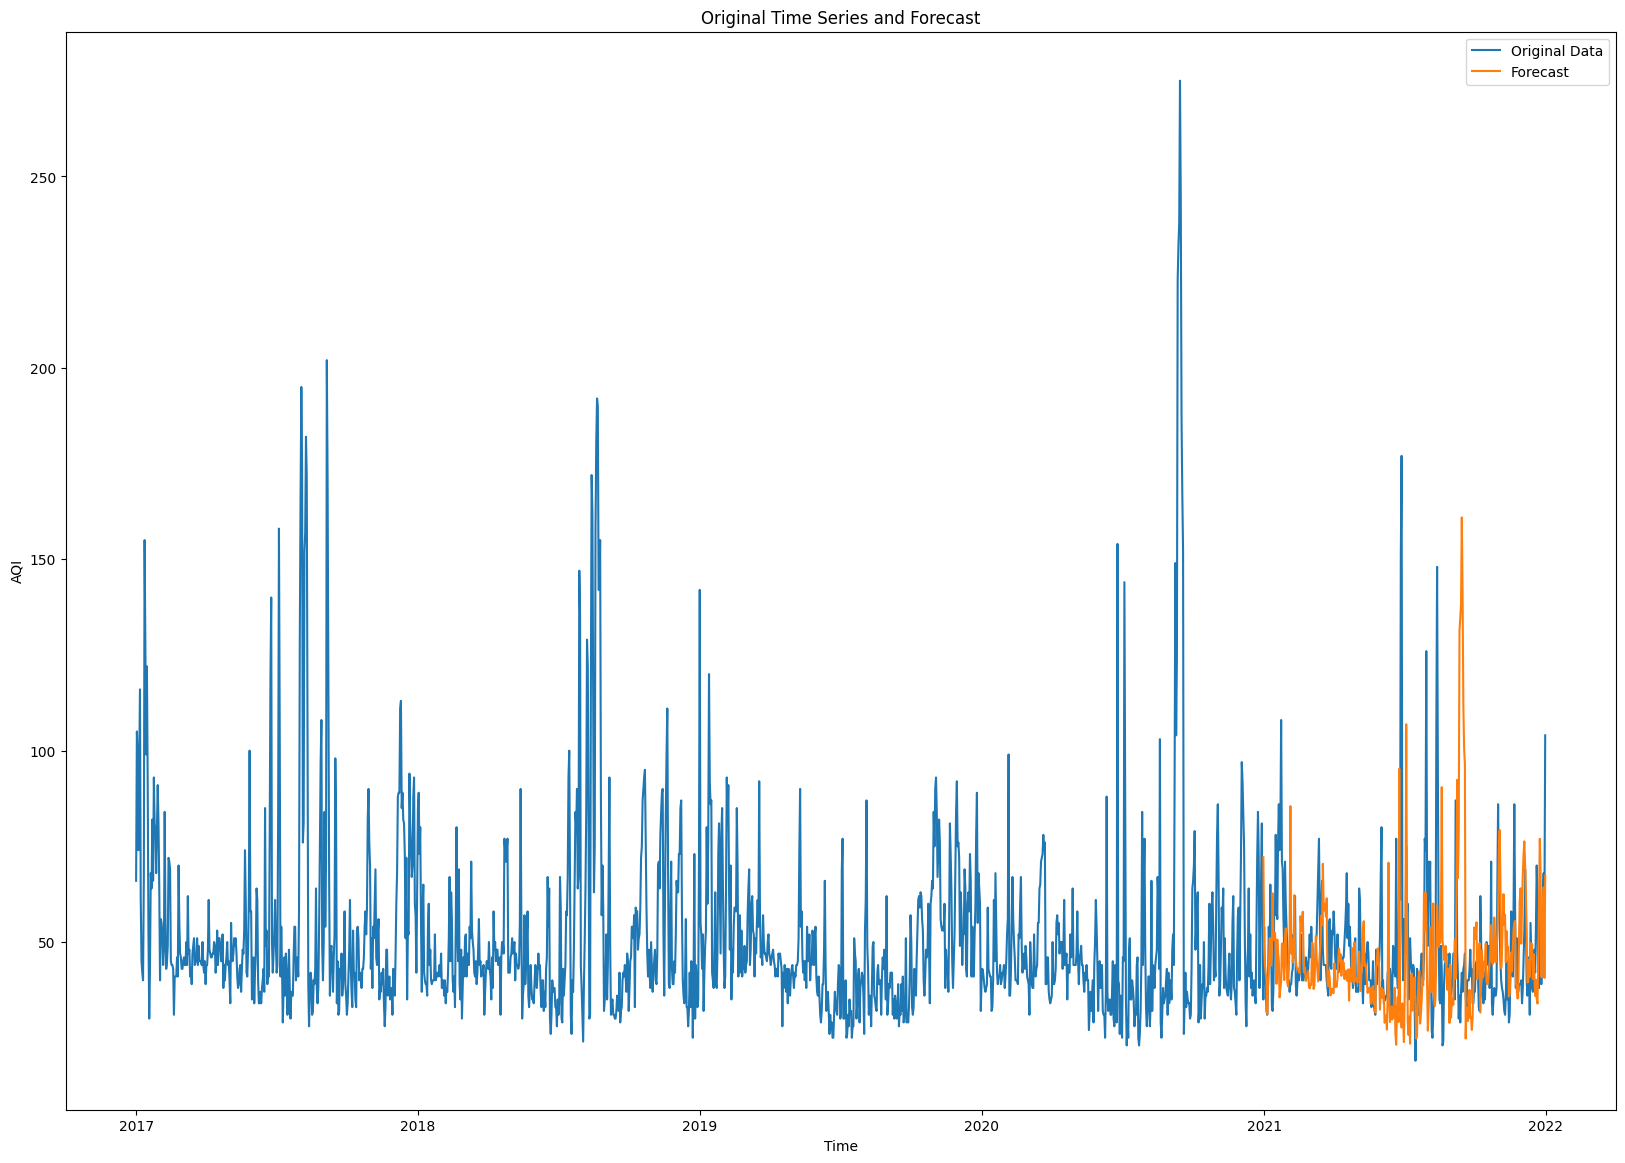

In [30]:
#Forecast the length of the test data
ts_pred_seasonal = model_fit_seasonal.forecast(steps=len(test_data))
#Time series forecasting adapted from code 

# Plot the original complete time series and overlay the forecast
plt.figure(figsize=(20, 14))
plt.plot(time_series, label='Original Data')
plt.plot(ts_pred_seasonal, label='Forecast')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Original Time Series and Forecast')
plt.legend()
plt.show()

We can see that our forecast behaves quite similarly to the actual test data, but also differs significantly, appearing to mimic spikes from the previous year that do not appear in the test data. For a numeric representation of the model's accuracy, we can now calculate the MAPE.

In [31]:
mape = mean_absolute_percentage_error(test_data, ts_pred_seasonal)
print("MAPE:", mape)

MAPE: 0.3019506175178925


The choice of evaluation metric (MAPE) was based primarily on its popularity as an indicator of practical accuracy in time series forecasting models. The cutoff value of 10% represents classification of the forecasting model as “highly accurate” by commonly accepted industry standards (Lewis, 1982). The drawback of this particular benchmark is that it sets a very high standard for our model’s success. However, the author ultimately concluded during the proposal phase of this analysis that the wide range of AQI values in the data necessitated more stringent criteria in our null and alternative hypotheses.

### E: DATA SUMMARY AND APPLICATIONS

As we can see, the MAPE of this model's forecast on the test data is just over 30%. According to Lewis' interpretation of MAPE results on time series models, this indicates that the forecasting accuracy of our model is classified as "reasonable," but does not approach the threshold we've established to reject our null hypothesis (1982). In order to fully convey the results of our analysis and discuss its implications, we must also field a discussion of the context of our research question and underlying business needs addressed therefrom.

As we recall, the research question of this analysis was “With what degree of accuracy can a time series model forecast daily AQI values for Seattle, Washington?” We sketched out several practical applications of this analysis related to the ability to regionally predict air quality and a resulting capacity to tailor future decisions related to health care resulting from exposure to poor air quality in a given region. This is a worthy subject of research, but over the course of this analysis, it became increasingly apparent that a time series model was completely unsuited to generate actionable insights related to our identified practical applications when we apply this technique to raw AQI data. This is largely due to the noisiness of raw AQI data, and this noisiness constitutes the most significant limitation of our analysis. AQI is a product of different measurements of  several airborne pollutants, all of which contribute to the index differently. In addition, patterns of air circulation in a region will result in wildly different calculated AQI values between measurement stations, all of which are averaged to generate an overall index of a given CBSA. These values can different significantly on a daily basis, without identifiable changes in external factors through which these variations can be explained. Even during annual wildfire seasons, lethargic wind patterns can enshroud a geographic region in hazardous particulate matter for weeks at a time, where a strong breeze can clear the entire area of smoke in a matter of hours. The occurrence of wildfires are also largely random, resulting from tragic confluences of droughts, unfavorable wind patterns, irresponsible human behavior, and even lightning strikes.

All of this contributes to completely unpredictable noise in the raw time series, rendering optimized time series models largely meaningless in the context of this type of forecasting. AQI is only predictive in that exposure to values at different thresholds among different demographics predict negative health outcomes based on the nature and length of exposure. In reality, AQI is a reactive index, calculated in response to a multitude of discrete and complex environmental conditions for the sole purpose of alerting the public to bodily danger. Accurately predicting the subsequent year’s daily AQI values is logically analogous to accurately forecasting the weather conditions necessary to produce a tornado using the same time delta. While we may be able to identify a season that is more statistically likely to demonstrate such behavior, this type of statistical model simply cannot produce accurate time series forecasting on a daily timeframe with this type of data.

This thesis is succinctly proven by the code snippet below, which demonstrates that a simple linear regression performed on the training data significantly outperforms our final time series model with a tested MAPE of just over 22%.

In [32]:
#Perform our linear regression on the training set of the time series
Dates = mdates.date2num(train_data.index)
z = np.polyfit(Dates, train_data, 1)
slope, intercept = np.polyfit(Dates, train_data, 1)
trendline = slope * Dates + intercept

#Extend the regression to the test set of the time series
trendline_test = np.array([trendline[-1] + slope])
for i in range(365):
    val = np.array([trendline_test[-1] + slope])
    trendline_test = np.concatenate((trendline_test, val))

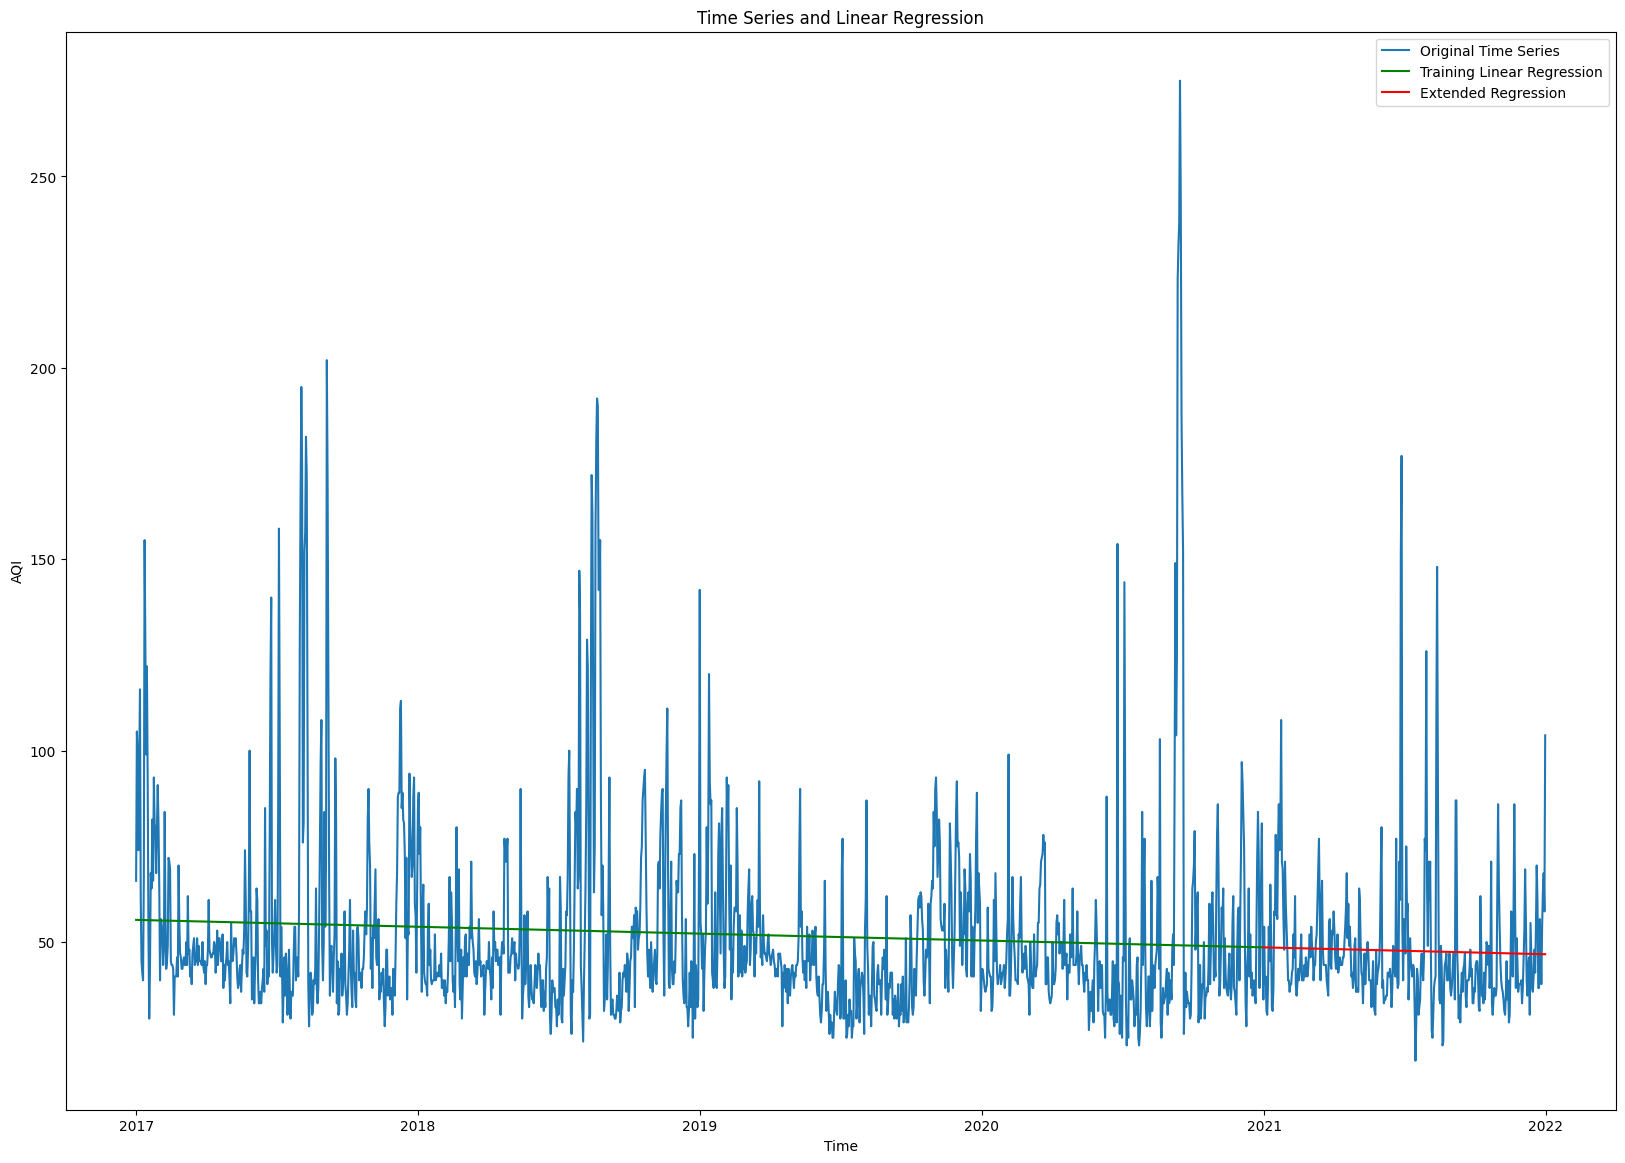

In [33]:
# Plot the original data and a forcast using a simple linear regression fit to the training data
plt.figure(figsize=(20, 14))
plt.plot(time_series, label='Original Time Series')
Dates_test = mdates.date2num(ts_pred_seasonal.index)
#z = np.polyfit(Dates, ts_pred_seasonal, 1)
#slope, intercept = np.polyfit(Dates, ts_pred_seasonal, 1)
#trendline = slope * Dates + intercept
plt.plot(Dates, trendline, color='g', label='Training Linear Regression')
plt.plot(Dates_test, trendline_test, color='r', label='Extended Regression')


plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Time Series and Linear Regression')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test_data, trendline_test)
print("MAPE:", mape)

MAPE: 0.22147230740413756


#### Course of Action and Alternative Recommendations

Regardless of the shortcomings of time series forecasting in the context of this analysis, the lessons learned from this process are still highly relevant in providing recommendations toward the end of addressing the underlying business needs of our initial research question. 

Based on the final model forecast's MAPE of 30%, we can answer our research question with the statement that a time series fit to the available data will result in reasonable forecasting accuracy over a forecasting period of 365 days. However, for the reasons discussed previously, we must strongly recommend that the methodology of this analysis be disregarded as a viable approach to understanding the relative air quality of a given region for the purposes of public health care-related organizational decision making. The complexity and computational demand of this methodology combined with its demonstrated inferiority to a simple linear regression clearly indicate that a time series model is not suited to inform the identified types of business decisions. 

Nevertheless, we can identify two future avenues of research to more adequately explore the use cases for a statistical regional understanding of air quality using this dataset.

The first method would seek to address the inherent noisiness of our raw data in order to generate better forecasting and regression models. If we were to apply smoothing techniques such as moving averages or exponential smoothing to our raw data, we would filter a great deal of the noise out of the time series, which would substantially simplify the construction of future generative models, producing results that more closely resemble seasonal trendlines than inaccurate spikes of trailing data. By then calculating the integral of the resulting time series plot (evaluating the total area under the forecast line on the plot), analysts would have a normalized quantitative metric by which to compare the air quality of different geographical regions over an arbitrary number of trailing years in subsequent analyses.

The second approach would be to disregard the quantitative measure of AQI altogether and instead evaluate a region's overall air quality based on the percentage of the total dataset represented by each class in the "Category" column of the source csv files. This column corresponds to the specific risk thresholds of AQI identified by the EPA, and would enable an analyst to drastically simplify how the air quality of a given region is conceptualized. These percentages would also then comprise a moving average of the data for an arbitrary trailing number of years, ultimately enabling analysts to evaluate our identified business needs.

Both methods would much more effectively distill this data to quantitative metrics that could easily be compared across regions and statistically evaluated against the geographical incidence of various medical conditions in future analyses.

### F: SOURCES: 

American Lung Association. (2022). Air Quality Index. https://www.lung.org/clean-air/outdoors/air-quality-index.

Duca, A. (2021). Understanding the Seasonal Order of the Sarima Model. https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa.

Fulton, C. (2019). Comment: "SARIMAX model too large #5727." https://github.com/statsmodels/statsmodels/issues/5727#issuecomment-492872310.

Lewis, C.D. (1982), Industrial and business forecasting methods: A practical guide
to exponential smoothing and curve fitting, London; Boston: Butterworth
Scientific.

US Environmental Protection Agency. (2017-2021). Air Quality System Data Mart [internet database] available via https://www.epa.gov/outdoor-air-quality-data. Accessed July 07, 2023. https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. 